In [ ]:
%%bash
# Create the conda environment from environment.yml (run in a terminal or notebook).
# This will create an env named 'soundanalyzer' with the required packages.
conda env create -f environment.yml || conda env update -f environment.yml
# After creating/updating the env, register the kernel (run in the terminal):
# conda activate soundanalyzer
# python -m ipykernel install --user --name soundanalyzer --display-name "Python (soundanalyzer)"
# Note: running conda env changes from inside an active kernel may not affect the current kernel session.


In [1]:
import numpy as np
import scipy.ndimage
import scipy.signal

class ERBSpectralProcessor:
    def __init__(self, sample_rate=44100, fft_size=4096, num_bands=60):
        self.sr = sample_rate
        self.fft_size = fft_size
        self.num_bands = num_bands  # Resolución visual (cuantas barras verás)
        
        # 1. Pre-calcular frecuencias FFT
        self.fft_freqs = np.fft.rfftfreq(fft_size, d=1/sample_rate)
        
        # 2. Construir el Banco de Filtros ERB
        self.filter_bank, self.center_freqs_hz = self._create_erb_filter_bank()
        
        # 3. Curva de Tilt (-3dB/oct compensación rosa)
        valid_freqs = np.maximum(self.fft_freqs, 1.0)
        self.tilt_curve = 3 * np.log2(valid_freqs)
        self.tilt_curve -= self.tilt_curve[0]

    def _hz_to_erb(self, freqs):
        return 21.4 * np.log10(0.00437 * freqs + 1)

    def _erb_to_hz(self, erb_nums):
        return (10**(erb_nums / 21.4) - 1) / 0.00437

    def _create_erb_filter_bank(self):
        min_freq = 20
        max_freq = self.sr / 2
        low_erb = self._hz_to_erb(min_freq)
        high_erb = self._hz_to_erb(max_freq)
        erb_points = np.linspace(low_erb, high_erb, self.num_bands + 2)
        hz_points = self._erb_to_hz(erb_points)
        bins = np.floor((self.fft_size + 1) * hz_points / self.sr).astype(int)
        
        fbank = np.zeros((self.num_bands, len(self.fft_freqs)))
        for m in range(1, self.num_bands + 1):
            f_m_minus, f_m, f_m_plus = bins[m-1], bins[m], bins[m+1]
            for k in range(f_m_minus, f_m):
                fbank[m-1, k] = (k - f_m_minus) / (f_m - f_m_minus)
            for k in range(f_m, f_m_plus):
                fbank[m-1, k] = (f_m_plus - k) / (f_m_plus - f_m)
        return fbank, hz_points[1:-1]

    def process_frame(self, audio_chunk, floor_factor=0.5):
        # Windowing y FFT
        window = np.hanning(len(audio_chunk))
        fft_raw = np.abs(np.fft.rfft(audio_chunk * window, n=self.fft_size))
        
        # Tilt Compensation (Lineal)
        tilt_linear = 10 ** (self.tilt_curve / 20)
        compensated_linear = fft_raw * tilt_linear
        
        # Conversión a dB para Noise Floor
        spectrum_db = 20 * np.log10(compensated_linear + 1e-9)
        
        # Noise Spectral Floor (Estimación del ruido de fondo)
        floor_db = scipy.ndimage.median_filter(spectrum_db, size=30)
        clean_db = spectrum_db - (floor_db * floor_factor)
        
        # Volver a lineal para sumar en bandas ERB
        clean_linear = 10**(clean_db / 20)
        
        # Suavizado ERB (Integración de energía)
        erb_energy = np.dot(self.filter_bank, clean_linear)
        erb_db = 20 * np.log10(erb_energy + 1e-9)

        return self.center_freqs_hz, erb_db

🎙️ GRABANDO (1.0s)... Genera tonos o ruido rosa.
⚙️ Procesando con Max-Pooling...


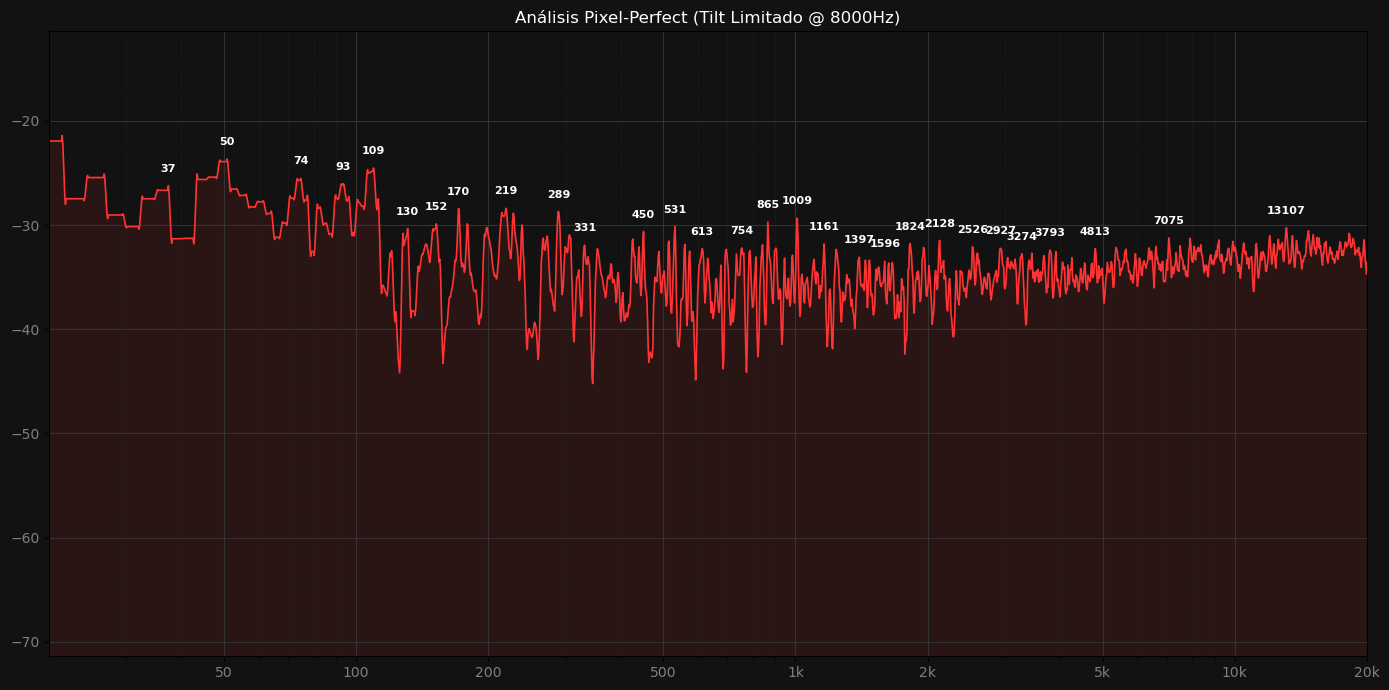

In [7]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import sounddevice as sd

# --- PARÁMETROS ---
FS = 44100
DURATION = 1.0      
FFT_SIZE = 16384    # Máxima resolución (0.7 Hz por bin) para graves perfectos
TILT_DB = 1       # Pendiente moderada
TILT_CEILING = 8000 # Frecuencia donde el Tilt deja de subir (evita la rampa final)

# --- 1. GRABACIÓN ---
print(f"🎙️ GRABANDO ({DURATION}s)... Genera tonos o ruido rosa.")
audio_data = sd.rec(int(DURATION * FS), samplerate=FS, channels=1, dtype='float32')
sd.wait()
audio_flat = audio_data.flatten()

# --- 2. MOTOR DE RENDERIZADO PIXEL-PERFECT ---
def get_pixel_perfect_curve(magnitude_db, freqs_linear, num_pixels=2000):
    """
    Mapea los bins de la FFT a píxeles de pantalla usando MAX-POOLING.
    Esto evita que la energía se 'acumule' en agudos.
    """
    # 1. Definir los bordes de los píxeles en escala Log
    pixel_edges = np.geomspace(20, FS/2, num_pixels + 1)
    
    pixel_freqs = []
    pixel_values = []
    
    # 2. Iterar por cada píxel de la pantalla
    # (Esto es muy rápido en Python moderno para 2000 puntos)
    for i in range(num_pixels):
        f_start = pixel_edges[i]
        f_end = pixel_edges[i+1]
        
        # Encontrar qué bins de la FFT caen dentro de este píxel
        # Usamos searchsorted para velocidad binaria
        idx_start = np.searchsorted(freqs_linear, f_start)
        idx_end = np.searchsorted(freqs_linear, f_end)
        
        # Centro visual del píxel
        center_freq = np.sqrt(f_start * f_end)
        pixel_freqs.append(center_freq)
        
        if idx_end > idx_start:
            # CASO NORMAL: Hay bins dentro de este píxel.
            # Tomamos el MÁXIMO (Peak detection), no el promedio.
            val = np.max(magnitude_db[idx_start:idx_end])
        else:
            # CASO GRAVES PROFUNDOS: El píxel es más estrecho que un bin FFT.
            # Tomamos el valor del bin más cercano (Interpolación Nearest)
            idx_nearest = min(max(idx_start, 0), len(magnitude_db)-1)
            val = magnitude_db[idx_nearest]
            
        pixel_values.append(val)
        
    return np.array(pixel_freqs), np.array(pixel_values)

# --- 3. PROCESAMIENTO (Peak Hold + Smart Tilt) ---
num_chunks = len(audio_flat) // FFT_SIZE
peak_spectrum_db = None

# Pre-calcular curva de Tilt inteligente
freqs_linear = np.fft.rfftfreq(FFT_SIZE, d=1/FS)
# Tilt logarítmico estándar
tilt_curve = TILT_DB * np.log2(np.maximum(freqs_linear, 20) / 20.0)
# APLICAR TECHO: A partir de 8kHz, la curva se vuelve plana (Shelf)
mask_ceiling = freqs_linear > TILT_CEILING
# Calculamos el valor de ganancia en el punto de corte
ceiling_gain = tilt_curve[np.searchsorted(freqs_linear, TILT_CEILING)]
# Fijamos todo lo que esté por encima de 8kHz a esa ganancia máxima
tilt_curve[mask_ceiling] = ceiling_gain 

print("⚙️ Procesando con Max-Pooling...")

for i in range(num_chunks):
    chunk = audio_flat[i*FFT_SIZE : (i+1)*FFT_SIZE]
    
    # A. FFT Pura
    window = np.blackman(len(chunk)) # Blackman tiene mejor separación de picos que Hann
    fft_raw = np.abs(np.fft.rfft(chunk * window, n=FFT_SIZE))
    
    # B. Magnitud dB
    mag_db = 20 * np.log10(fft_raw + 1e-12)
    
    # C. Aplicar Tilt Pre-Calculado
    mag_db += tilt_curve
    
    # D. Peak Hold Histórico (en resolución nativa FFT)
    if peak_spectrum_db is None:
        peak_spectrum_db = mag_db
    else:
        peak_spectrum_db = np.maximum(peak_spectrum_db, mag_db)

# --- 4. RENDERIZADO ---
# Aquí ocurre la magia: Convertimos los 8193 bins a 2000 píxeles "limpios"
f_plot, curve_plot = get_pixel_perfect_curve(peak_spectrum_db, freqs_linear, num_pixels=2000)

# Suavizado cosmético final (muy leve, solo para quitar dientes de sierra)
curve_smooth = scipy.signal.savgol_filter(curve_plot, window_length=7, polyorder=2)

# Detección de picos para etiquetas
peaks, props = scipy.signal.find_peaks(curve_smooth, distance=30, prominence=4)

# --- 5. VISUALIZACIÓN ---
plt.figure(figsize=(14, 7), facecolor='#121212')
ax = plt.gca()
ax.set_facecolor('#121212')

# Curva principal
plt.plot(f_plot, curve_smooth, color='#ff3333', linewidth=1.2, label='Peak Max-Pooling')
plt.fill_between(f_plot, curve_smooth, -120, color='#ff3333', alpha=0.1)

# Etiquetas
for i in peaks:
    plt.annotate(f"{int(f_plot[i])}", xy=(f_plot[i], curve_smooth[i]), 
                 xytext=(0, 10), textcoords='offset points', ha='center', 
                 color='white', fontsize=8, fontweight='bold')

plt.xscale('log')
plt.xlim(20, 20000)
# Zoom automático inteligente
y_max = np.max(curve_smooth) + 10
plt.ylim(y_max - 60, y_max) 

# Decoración
plt.grid(which='major', color='#333333', linestyle='-')
plt.grid(which='minor', color='#222222', linestyle=':')
plt.xticks([50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], 
           ['50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'], color='grey')
plt.yticks(color='grey')
plt.title(f"Análisis Pixel-Perfect (Tilt Limitado @ {TILT_CEILING}Hz)", color='white')

plt.tight_layout()
plt.show()